In [19]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import lagrange


### But

Le but du nouveau code est d'ajouter la contribution des flux d'eau latéraux à nos équations de température et de charge. L'équipe de 2024 avait pour cela rajouté un terme source volumique q dans l'équation 1D, ce qui ne fait pas de sens selon nous car le flux d'eau ne fait que transiter de droite à gauche (ou de gauche à droite) de l'aquifère, le bilan total net sur le capteur est donc nul si l'on isole une tranche dz pour réaliser le bilan (même quantité entrante et sortante).


### Discrétisation

Nous proposons donc une nouvelle approche, plus rigoureuse physiquement. Les équations seront traitées en 2D sur un maillage régulier qui sera centrée sur notre capteur. Il sera considéré fin en largeur, le but n'étant pas de résoudre en 2D sur toute l'aquifère. Les points supplémentaires en largeur sont donc des intermédiaires de calcul qui nous permettront d'implémenter le flux latéral d'eau comme une condition de Neumann sur notre maillage. Les équations traitées sont les suivantes :

$$S_s \frac{\partial H}{\partial t} = K \Delta H$$ \\ $$\frac{\partial T}{\partial t} = \kappa_e \Delta T + \alpha_e \nabla H \cdot \nabla T$$

Pour les traiter, on utilise comme précedemment un schéma de Crank-Nicolson régi par un paramètre $\alpha$ tel que le schéma soit explicite pour $\alpha=1$ et implicite pour $\alpha=0$. Pour les variables, on utilisera la notation suivante $U^{n}_{i,j}$ avec n l'indice temporel, i l'indice de l'axe z vertical, et j l'indice de l'axe x horizontal.
Les discrétisations sont les suivantes :

$$
\small
S_s \frac{H_{i,j}^{n+1} - H_{i,j}^{n}}{\Delta t} = \alpha K \left[ \frac{H_{i+1,j}^n - 2H_{i,j}^n + H_{i-1,j}^n}{(\Delta z)^2} + \frac{H_{i,j+1}^n - 2H_{i,j}^n + H_{i,j-1}^n}{(\Delta x)^2} \right] + (1-\alpha) K \left[ \frac{H_{i+1,j}^{n+1} - 2H_{i,j}^{n+1} + H_{i-1,j}^{n+1}}{(\Delta z)^2} + \frac{H_{i,j+1}^{n+1} - 2H_{i,j}^{n+1} + H_{i,j-1}^{n+1}}{(\Delta x)^2} \right]
$$ \\

$$
\small 
\frac{T_{i,j}^{n+1} - T_{i,j}^{n}}{\Delta t} = 
\alpha \left\{ \kappa_e \left[ \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{(\Delta z)^2} + \frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{(\Delta x)^2} \right] + \alpha_e \left[ \left(\frac{H_{i+1,j}^n - H_{i-1,j}^n}{2\Delta z}\right)\left(\frac{T_{i+1,j}^n - T_{i-1,j}^n}{2\Delta z}\right) + \left(\frac{H_{i,j+1}^n - H_{i,j-1}^n}{2\Delta x}\right)\left(\frac{T_{i,j+1}^n - T_{i,j-1}^n}{2\Delta x}\right) \right] \right\} \\
+ (1-\alpha) \left\{ \kappa_e \left[ \frac{T_{i+1,j}^{n+1} - 2T_{i,j}^{n+1} + T_{i-1,j}^{n+1}}{(\Delta z)^2} + \frac{T_{i,j+1}^{n+1} - 2T_{i,j}^{n+1} + T_{i,j-1}^{n+1}}{(\Delta x)^2} \right] + \alpha_e \left[ \left(\frac{H_{i+1,j}^n - H_{i-1,j}^n}{2\Delta z}\right)\left(\frac{T_{i+1,j}^{n+1} - T_{i-1,j}^{n+1}}{2\Delta z}\right) + \left(\frac{H_{i,j+1}^n - H_{i,j-1}^n}{2\Delta x}\right)\left(\frac{T_{i,j+1}^{n+1} - T_{i,j-1}^{n+1}}{2\Delta x}\right) \right] \right\}
$$


### Conditions initiales

Rajouter une dimension rajoute des conditions aux limites. Etant donné que le capteur ne donne qu'une mesure selon z, on ne peut pas être précis sur la dimension selon x. C'est pourquoi on considérera que notre grille est fine selon x. Ainsi, on peut considérer que l'interpolation de Lagrange et l'interpolation linéaire réalisée l'année dernière pour avoir le profil initial selon z peut s'étendre à tout x. On a donc le même profil que précedemment (interpolation d'ordre 5 sur les 5 mesures de température et Linéaire entre les deux mesures de charge pour H).

$$\begin{cases}
H(z, {x}, t=0) \\ 
T(z, {x}, t=0) 
\end{cases} \quad
\text{ Ne dependent pas de x, calcules par interpolation sur les points de mesure initiaux au profondeur discretes}
$$ 


### Conditions aux limites 

De même pour les conditions aux limites de température, on considérera que les conditions de Dirichlet utilisées à la surface et à la profondeur maximale sont étendables pour tout x.
Pour les bords latéraux de notre maillage, on considérera une condition de Neumann constante. On impose un flux uniforme $q_L$ d'eau de température $T_L$ à gauche. Par conservation du flux sur une tranche infinitésimal (la largeur du maillage étant négligeable devant la longueur), on a que le flux entrant latéral est le flux sortant latéral de l'autre côté.

$$\text{Bords up and down, conditions de Dirichlet} \quad \begin{cases} T(z=0,x,t) = T_{riv}(t) \\ T(z=h,x,t) = T_{aq}(t) \end{cases}$$

$$\text{Bords lateraux, conditions de Neumann} \quad \begin{cases} T_{i,-1} = T_{i,1} - \frac{2\Delta x \cdot \rho_w c_w q_L}{\kappa_e} (T_L - T_{i,0}) \\ \kappa_e \frac{T_{i,N_x} - T_{i,-1}}{2\Delta x} = \rho_w c_w q_L (T_L - T_{i,0}) \end{cases}$$


### Traitement numérique

La discrétisation dictée précédemment peut se mettre sous la forme $A(\alpha) X^{n+1}=A^{'}(\alpha)X^{n}$. On choisira de dérouler l'espace selon les lignes de notre maillage. La matrice A est donc de taille $(N_x N_z)^{2}$, et le point $(i,j)$ sera donc indicé $k = I N_x + j$ dans le vecteur déroulé.
On cherche à résoudre $A X^{n+1}=B(X^{n})$. La matrice A étant constante, on ne calculera qu'une seule fois sa décomposition LU. Ensuite, on appliquera successivement toutes les 15 minutes (temps de mesure) l'algorithme de scipy en actualisant le vecteur $B(X^{n})$ qui dépend de l'état précédent et des conditions aux limites. Le code renvoie la valeur de température en $x = L_x / 2$ car la seule chose qui nous intéresse est ce qui passe au niveau du capteur, les autres points étant uniquement des intermédiaires physiques de calcul.



Fonction de résolution

In [20]:
def solve_2D_charge_step(H_prev, K, Ss, dt, dz, dx, alpha, bc_types, bc_values):
    """
    Calcule un pas de temps de l'équation de diffusion 2D avec des BC flexibles.
    bc_types: Tuple(str, str, str, str) -> (haut, bas, gauche, droite)
    bc_values: Tuple(float, float, float, float) -> valeurs associées
    """
    Nz, Nx = H_prev.shape
    N = Nz * Nx
    A = lil_matrix((N, N))
    b = np.zeros(N)
    coef_z, coef_x = K / dz**2, K / dx**2
    bc_top, bc_bottom, bc_left, bc_right = bc_types
    val_top, val_bottom, val_left, val_right = bc_values
    source_scaling_factor = dt / Ss

    for i in range(Nz):
        for j in range(Nx):
            k = i * Nx + j
            if i == 0:
                if bc_top == 'dirichlet': A[k, k], b[k] = 1.0, val_top
            elif i == Nz - 1:
                if bc_bottom == 'dirichlet': A[k, k], b[k] = 1.0, val_bottom
            elif j == 0:
                if bc_left == 'dirichlet': A[k, k], b[k] = 1.0, val_left
                elif bc_left == 'neumann':
                    A[k, k] = Ss/dt + 2*(1-alpha)*(coef_z+coef_x)
                    A[k, k-Nx], A[k, k+Nx] = -(1-alpha)*coef_z, -(1-alpha)*coef_z
                    A[k, k+1] = -2*(1-alpha)*coef_x
                    source_term = (2 * val_left / dx)
                    b[k] = ((Ss/dt-2*alpha*(coef_z+coef_x))*H_prev[i,j] + alpha*coef_z*(H_prev[i-1,j]+H_prev[i+1,j]) + (2*alpha*coef_x)*H_prev[i,j+1]) + source_term
            elif j == Nx - 1:
                if bc_right == 'dirichlet': A[k, k], b[k] = 1.0, val_right
                elif bc_right == 'neumann':
                    A[k, k] = Ss/dt + 2*(1-alpha)*(coef_z+coef_x)
                    A[k, k-Nx], A[k, k+Nx] = -(1-alpha)*coef_z, -(1-alpha)*coef_z
                    A[k, k-1] = -2*(1-alpha)*coef_x
                    source_term = (2 * val_right / dx)
                    b[k] = ((Ss/dt-2*alpha*(coef_z+coef_x))*H_prev[i,j] + alpha*coef_z*(H_prev[i-1,j]+H_prev[i+1,j]) + (2*alpha*coef_x)*H_prev[i,j-1]) + source_term
            else:
                A[k, k] = Ss/dt + 2*(1-alpha)*(coef_z+coef_x)
                A[k, k-Nx], A[k, k+Nx] = -(1-alpha)*coef_z, -(1-alpha)*coef_z
                A[k, k-1], A[k, k+1] = -(1-alpha)*coef_x, -(1-alpha)*coef_x
                b[k] = ((Ss/dt - 2*alpha*(coef_z+coef_x))*H_prev[i,j] + (alpha*coef_z)*(H_prev[i+1,j]+H_prev[i-1,j]) + (alpha*coef_x)*(H_prev[i,j+1]+H_prev[i,j-1]))
    
    h_new_flat = spsolve(A.tocsr(), b)
    return h_new_flat.reshape((Nz, Nx))

In [21]:
# Remplacez votre fonction de température par celle-ci
def solve_2d_temperature_step(T_prev, grad_H_z, grad_H_x, K, Ss, n, lambda_s, rhos_cs, dt, dz, dx, alpha, bc_types, bc_values):
    Nz, Nx = T_prev.shape
    N = Nz * Nx
    A = lil_matrix((N, N))
    b = np.zeros(N)
    RHO_W, C_W, LAMBDA_W = 1000.0, 4185.0, 0.6
    rho_mc_m = n * RHO_W * C_W + (1 - n) * rhos_cs
    lambda_m = (n * (LAMBDA_W)**0.5 + (1 - n) * (lambda_s)**0.5)**2
    kappa_e = lambda_m / rho_mc_m
    alpha_e = (RHO_W * C_W * K) / rho_mc_m
    coef_diff_z, coef_diff_x = kappa_e / dz**2, kappa_e / dx**2
    coef_adv_z, coef_adv_x = alpha_e / (2 * dz), alpha_e / (2 * dx)
    bc_top, bc_bottom, bc_left, bc_right = bc_types
    val_top, val_bottom, val_left, val_right = bc_values
    
    # Le flux de chaleur n'est pas lié au stockage Ss, mais directement à la température
    source_scaling_factor_T = 1 / rho_mc_m

    for i in range(Nz):
        for j in range(Nx):
            k = i * Nx + j
            if i == 0:
                if bc_top == 'dirichlet': A[k, k], b[k] = 1.0, val_top
            elif i == Nz - 1:
                if bc_bottom == 'dirichlet': A[k, k], b[k] = 1.0, val_bottom
            elif j == 0:
                if bc_left == 'neumann':
                    A[k, k]     = 1/dt + 2*(1-alpha)*(coef_diff_z + coef_diff_x)
                    A[k, k-Nx]   = -(1-alpha)*coef_diff_z - (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k+Nx]   = -(1-alpha)*coef_diff_z + (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k+1]   = -2*(1-alpha)*coef_diff_x
                    # ====================== CORRECTION NEUMANN ======================
                    source_term = (2 * val_left / dx)*source_scaling_factor_T
                    b[k] = ( (1/dt - 2*alpha*(coef_diff_z + coef_diff_x))*T_prev[i,j] + \
                           (alpha*coef_diff_z + alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i-1,j] + \
                           (alpha*coef_diff_z - alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i+1,j] + \
                           (2*alpha*coef_diff_x)*T_prev[i,j+1] ) + source_term
                    # ===============================================================
            elif j == Nx - 1:
                if bc_right == 'neumann':
                    A[k, k]     = 1/dt + 2*(1-alpha)*(coef_diff_z + coef_diff_x)
                    A[k, k-Nx]   = -(1-alpha)*coef_diff_z - (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k+Nx]   = -(1-alpha)*coef_diff_z + (1-alpha)*coef_adv_z*grad_H_z[i,j]
                    A[k, k-1]   = -2*(1-alpha)*coef_diff_x
                    # ====================== CORRECTION NEUMANN ======================
                    source_term = (2 * val_right / dx)*source_scaling_factor_T
                    b[k] = ( (1/dt - 2*alpha*(coef_diff_z + coef_diff_x))*T_prev[i,j] + \
                           (alpha*coef_diff_z + alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i-1,j] + \
                           (alpha*coef_diff_z - alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i+1,j] + \
                           (2*alpha*coef_diff_x)*T_prev[i,j-1] ) + source_term
                    # ===============================================================
            else:
                A[k, k]     = 1/dt + 2*(1-alpha)*(coef_diff_z + coef_diff_x)
                A[k, k-Nx]   = -(1-alpha)*coef_diff_z - (1-alpha)*coef_adv_z*grad_H_z[i,j]
                A[k, k+Nx]   = -(1-alpha)*coef_diff_z + (1-alpha)*coef_adv_z*grad_H_z[i,j]
                A[k, k-1]   = -(1-alpha)*coef_diff_x - (1-alpha)*coef_adv_x*grad_H_x[i,j]
                A[k, k+1]   = -(1-alpha)*coef_diff_x + (1-alpha)*coef_adv_x*grad_H_x[i,j]
                b[k] = ( (1/dt - 2*alpha*(coef_diff_z + coef_diff_x))*T_prev[i,j] + \
                       (alpha*coef_diff_z + alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i-1,j] + \
                       (alpha*coef_diff_z - alpha*coef_adv_z*grad_H_z[i,j])*T_prev[i+1,j] + \
                       (alpha*coef_diff_x + alpha*coef_adv_x*grad_H_x[i,j])*T_prev[i,j-1] + \
                       (alpha*coef_diff_x - alpha*coef_adv_x*grad_H_x[i,j])*T_prev[i,j+1] )

    T_new_flat = spsolve(A.tocsr(), b)
    return T_new_flat.reshape((Nz, Nx))

Paramètres du problème

In [22]:
# Géométrie
Nz, Nx = 101, 26
Lz, Lx = 0.4, 0.1
dz, dx = Lz / (Nz - 1), Lx / (Nx - 1)

# Physique (tiré de vos informations sauvegardées)
K = 1e-5
n = 0.1
Ss = n / Lz
lambda_s = 2
rhos_cs = 4e6

# Temps
total_time = 3600*24
dt = 300
n_steps = int(total_time / dt)
alpha = 0.5

Simulation de H

In [23]:
print("--- Début de la simulation pour H ---")
bc_types_H = ('dirichlet', 'dirichlet', 'neumann', 'neumann')
bc_values_H = (0.85, 0.0, 1e-5, -1e-5)
H_results = np.zeros((Nz, Nx, n_steps + 1))
H_profil_z = np.linspace(bc_values_H[0], bc_values_H[1], Nz)
H_results[:, :, 0] = np.tile(H_profil_z.reshape(-1, 1), (1, Nx))

for i in tqdm(range(n_steps), desc="Simulation H"):
    H_results[:, :, i+1] = solve_2D_charge_step(
        H_results[:, :, i], K, Ss, dt, dz, dx, alpha, bc_types_H, bc_values_H
    )
print("--- Simulation H terminée ---")

--- Début de la simulation pour H ---


Simulation H: 100%|██████████| 288/288 [00:17<00:00, 16.70it/s]

--- Simulation H terminée ---


Visulisation de la charge

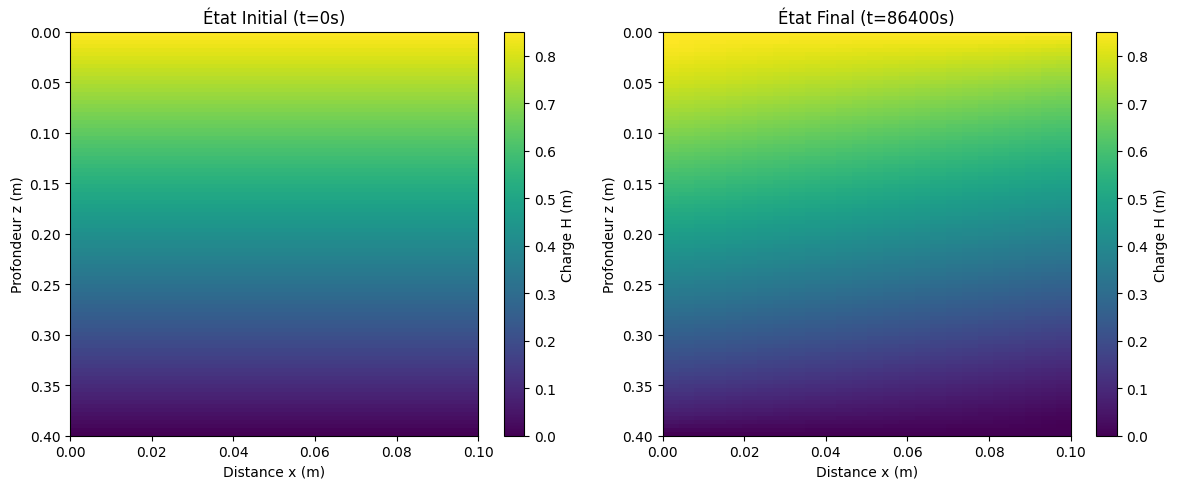

In [24]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# État initial
im0 = axes[0].imshow(H_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0].set_title("État Initial (t=0s)")
axes[0].set_xlabel("Distance x (m)"), axes[0].set_ylabel("Profondeur z (m)")
fig.colorbar(im0, ax=axes[0], label="Charge H (m)")
# État final
im1 = axes[1].imshow(H_results[:, :, -1], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[1].set_title(f"État Final (t={total_time}s)")
axes[1].set_xlabel("Distance x (m)"), axes[1].set_ylabel("Profondeur z (m)")
fig.colorbar(im1, ax=axes[1], label="Charge H (m)")
plt.tight_layout()
plt.show()


Profil de température initial

Calcul de gradients de la charge

In [25]:
print("Calcul des gradients de H...")
grad_H_z_all_steps = np.zeros_like(H_results)
grad_H_x_all_steps = np.zeros_like(H_results)
for i in range(H_results.shape[2]):
    gradients = np.gradient(H_results[:, :, i], dz, dx)
    grad_H_z_all_steps[:, :, i] = gradients[0]
    grad_H_x_all_steps[:, :, i] = gradients[1]
print("Calcul des gradients terminé.")


Calcul des gradients de H...
Calcul des gradients terminé.


Simulation de la température

In [26]:
print("\n--- Début de la simulation pour T ---")
# Condition initiale pour T via interpolation
T_mesures = np.array([287.159, 287.248, 287.32, 287.272, 287.08]) - 273.15
z_mesures = np.linspace(0, Lz, len(T_mesures))
poly_lagrange = lagrange(z_mesures, T_mesures)
z_grid = np.linspace(0, Lz, Nz)
T_init_1D = poly_lagrange(z_grid)
T_init_2D = np.tile(T_init_1D.reshape(-1, 1), (1, Nx))

# Conditions aux limites pour T (Dirichlet haut/bas, Neumann côtés)
bc_types_T = ('dirichlet', 'dirichlet', 'neumann', 'neumann')
bc_values_T = (T_init_1D[0], T_init_1D[-1], 0, 0) # Températures basées sur l'IC, flux nul

# Initialisation et boucle
T_results = np.zeros((Nz, Nx, n_steps + 1))
T_results[:, :, 0] = T_init_2D
for i in tqdm(range(n_steps), desc="Simulation T"):
    T_results[:, :, i+1] = solve_2d_temperature_step(
        T_prev=T_results[:, :, i], 
        grad_H_z=grad_H_z_all_steps[:, :, i], 
        grad_H_x=grad_H_x_all_steps[:, :, i],
        K=K, Ss=Ss, n=n, lambda_s=lambda_s, rhos_cs=rhos_cs,
        dt=dt, dz=dz, dx=dx, alpha=alpha,
        bc_types=bc_types_T, bc_values=bc_values_T
    )
print("--- Simulation T terminée ---")


--- Début de la simulation pour T ---


Simulation T: 100%|██████████| 288/288 [00:20<00:00, 14.00it/s]

--- Simulation T terminée ---


Affichage des résultats

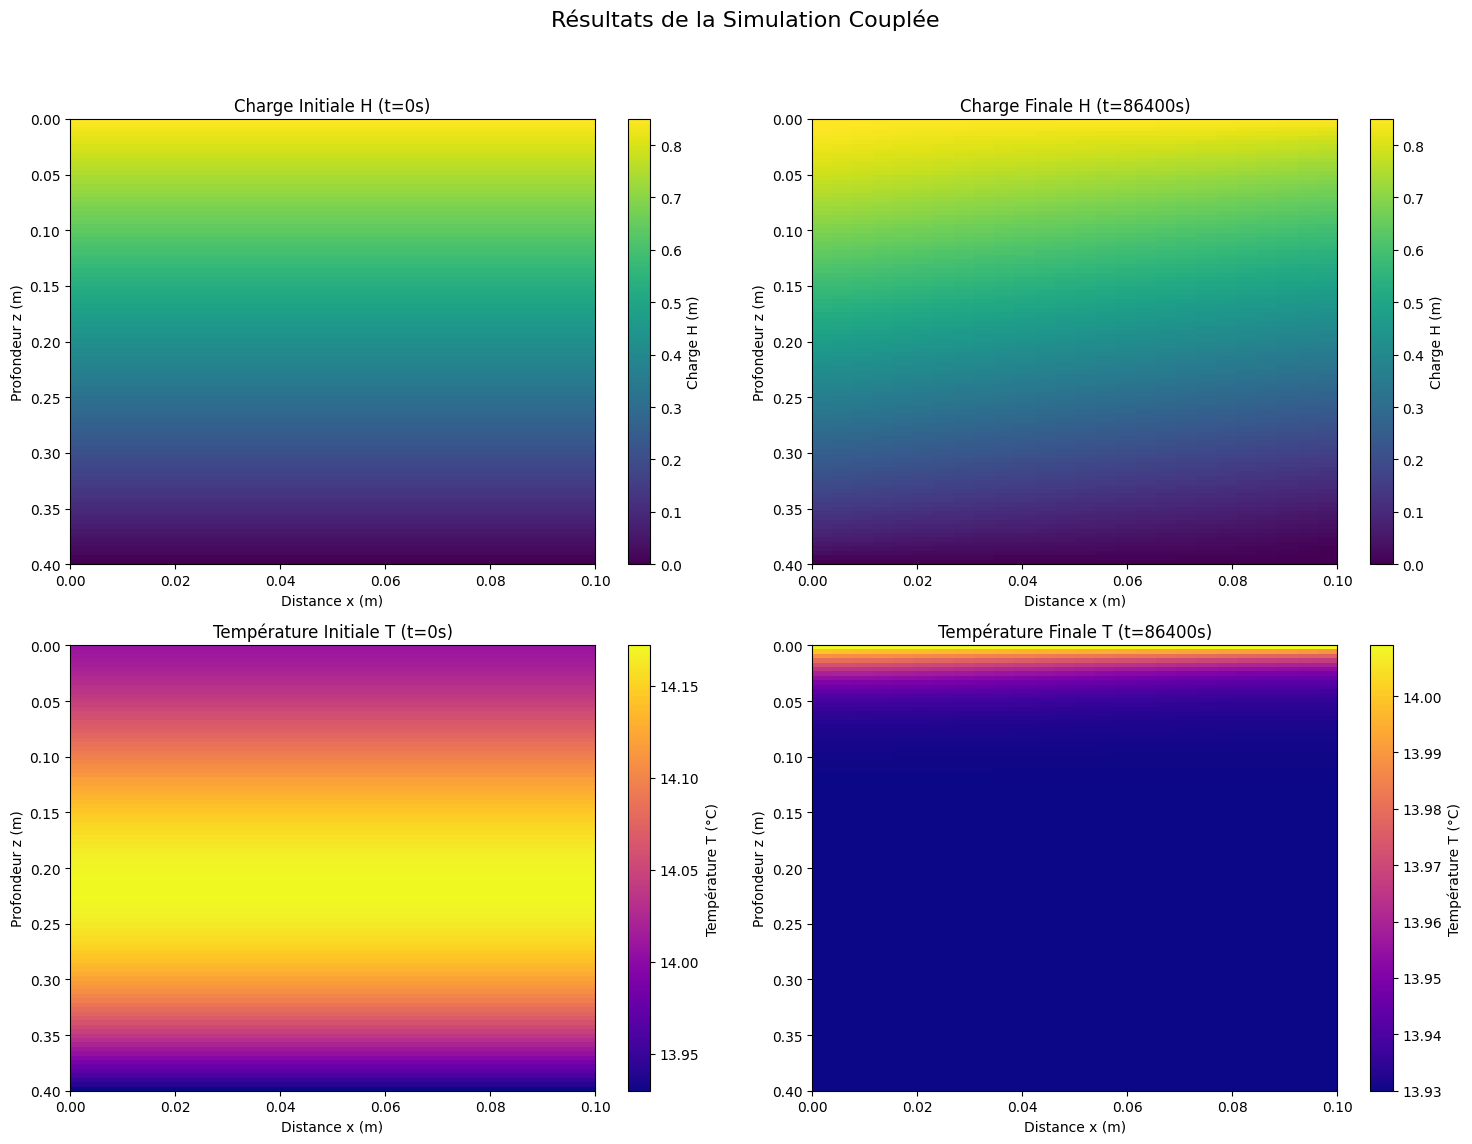

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Résultats de la Simulation Couplée', fontsize=16)

# -- Affichage de H --
im0 = axes[0, 0].imshow(H_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0, 0].set_title("Charge Initiale H (t=0s)")
fig.colorbar(im0, ax=axes[0, 0], label="Charge H (m)")

im1 = axes[0, 1].imshow(H_results[:, :, -1], extent=[0, Lx, Lz, 0], aspect='auto', cmap='viridis')
axes[0, 1].set_title(f"Charge Finale H (t={total_time}s)")
fig.colorbar(im1, ax=axes[0, 1], label="Charge H (m)")

# -- Affichage de T --
im2 = axes[1, 0].imshow(T_results[:, :, 0], extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma')
axes[1, 0].set_title("Température Initiale T (t=0s)")
fig.colorbar(im2, ax=axes[1, 0], label="Température T (°C)")

im3 = axes[1, 1].imshow(T_results[:, :, -1], extent=[0, Lx, Lz, 0], aspect='auto', cmap='plasma')
axes[1, 1].set_title(f"Température Finale T (t={total_time}s)")
fig.colorbar(im3, ax=axes[1, 1], label="Température T (°C)")

for ax in axes.flat:
    ax.set_xlabel("Distance x (m)")
    ax.set_ylabel("Profondeur z (m)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
